In [100]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
import networkx as nx
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [2]:
!python -m spacy download en_core_web_sm

     -------------------------------------- 12.8/12.8 MB 232.2 kB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
# Load spacy English Langauge Model, NER --> Named Entity Recognition
NER = spacy.load("en_core_web_sm")

## Load books

In [6]:
import os 

all_books = [b for b in os.scandir('data') if '.txt' in b.name]

In [9]:
all_books

[<DirEntry 'B - The Sword of Destiny.txt'>,
 <DirEntry 'C - The Last Wish.txt'>,
 <DirEntry 'E - something ends something begins.txt'>,
 <DirEntry 'I - Blood of Elves.txt'>,
 <DirEntry 'II - Times of Contempt.txt'>,
 <DirEntry 'III - Baptism of Fire.txt'>,
 <DirEntry 'IV - The Tower of the Swallow.txt'>,
 <DirEntry 'V - The Lady of the Lake.txt'>]

In [10]:
all_books[0]

<DirEntry 'B - The Sword of Destiny.txt'>

In [11]:
book = all_books[1]
book_text = open(book).read()
book_doc = NER(book_text)

In [14]:
displacy.render(book_doc[:1000], style="ent", jupyter=True)

In [17]:
## load characters data
characters_df = pickle.load(open("the_witcher_characters_data.pkl", "rb"))

In [24]:
pd.set_option("display.max_rows", None)

In [28]:
characters_df[:15]

,Book,Character
0,Category:Baptism of Fire characters,Adalia
1,Category:Baptism of Fire characters,Adela
2,Category:Baptism of Fire characters,Aen Saevherne
3,Category:Baptism of Fire characters,Aevenien
4,Category:Baptism of Fire characters,Aglaïs
5,Category:Baptism of Fire characters,Albrich
6,Category:Baptism of Fire characters,Amavet
7,Category:Baptism of Fire characters,Angus Bri Cri
8,Category:Baptism of Fire characters,Anna Kameny
9,Category:Baptism of Fire characters,Anzelm Aubry


In [29]:
## remove brackets and characters within brackets
import re
characters_df["Character"] = characters_df["Character"].apply(lambda x: re.sub(r"\([^()]*\)", "", x))
characters_df["character_firstname"] = characters_df["Character"].apply(lambda x: x.split(" ")[0])

In [31]:
characters_df[:15]

,Book,Character,character_firstname
0,Category:Baptism of Fire characters,Adalia,Adalia
1,Category:Baptism of Fire characters,Adela,Adela
2,Category:Baptism of Fire characters,Aen Saevherne,Aen
3,Category:Baptism of Fire characters,Aevenien,Aevenien
4,Category:Baptism of Fire characters,Aglaïs,Aglaïs
5,Category:Baptism of Fire characters,Albrich,Albrich
6,Category:Baptism of Fire characters,Amavet,Amavet
7,Category:Baptism of Fire characters,Angus Bri Cri,Angus
8,Category:Baptism of Fire characters,Anna Kameny,Anna
9,Category:Baptism of Fire characters,Anzelm Aubry,Anzelm


## Get named entity list per sentence

In [37]:
sent_entity_df = []

for sent in book_doc.sents :
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence" : sent, "entities" : entity_list})
                           
sent_entity_df = pd.DataFrame(sent_entity_df)

In [38]:
sent_entity_df[:10]

,sentence,entities
0,"(ï»¿'Does, she, always, devour, her, victims, ...",[]
1,"(\n\n, Velerad, spat, vehemently, on, the, str...",[Velerad]
2,"(\n\n, ', Come, on, ,, Geralt, ,, it, 'll, be,...",[Geralt]
3,"(Pish, !)",[]
4,"(Devours, ,, takes, a, bite, ,, leaves, aside,...",[]
5,"(She, only, bit, the, head, from, one, ,, gutt...",[]
6,"(Damned, mother's-, !, ')",[]
7,"(\n\n, ', Careful, ,, Velerad, ,, ', snarled, ...","[Velerad, Ostrit]"
8,"(', Say, what, you, want, about, the, striga, ...",[Adda]
9,"(\n\n, ', Has, anyone, she, 's, attacked, surv...",[]


In [39]:
## filter out non-character entities
def filter_entities(ent_list, characters_df) :
    return [ent for ent in ent_list
           if ent in list(characters_df.Character) or 
           ent in list(characters_df.character_firstname)]

In [41]:
filter_entities(["Geralt", "chet", 3], characters_df)

['Geralt']

In [46]:
sent_entity_df["character_entities"] = sent_entity_df["entities"].apply(lambda x: filter_entities(x, characters_df))

## remove sentences with no entities
sent_entity_filtered = sent_entity_df[sent_entity_df["character_entities"].map(len)>0]

In [50]:
sent_entity_filtered[:5]

,sentence,entities,character_entities
1,"(\n\n, Velerad, spat, vehemently, on, the, str...",[Velerad],[Velerad]
2,"(\n\n, ', Come, on, ,, Geralt, ,, it, 'll, be,...",[Geralt],[Geralt]
7,"(\n\n, ', Careful, ,, Velerad, ,, ', snarled, ...","[Velerad, Ostrit]","[Velerad, Ostrit]"
8,"(', Say, what, you, want, about, the, striga, ...",[Adda],[Adda]
11,"(\n\n, Segelin, and, Ostrit, looked, at, each,...","[Segelin, Ostrit]","[Segelin, Ostrit]"


In [53]:
## take only first name of characters
sent_entity_filtered["character_entities"] = sent_entity_filtered["character_entities"].apply(lambda x: [item.split(" ")[0] for item in x])

## Create relationships

In [73]:
window_size = 5
relationships = []

for i in range(sent_entity_filtered.index[-1]) :
    end_i = min(i+5, sent_entity_filtered.index[-1])
    char_list = sum((sent_entity_filtered.iloc[i: end_i].character_entities), [])
    
    ## remove duplicated characters from the lists
    char_unique = list(Counter(char_list).keys())
    
    if len(char_unique)>1 :
        for idx, a in enumerate(char_unique[:-1]) :
            b = char_unique[idx+1]
            relationships.append({"source" : a, "target" : b})

In [74]:
relationship_df = pd.DataFrame(relationships)
relationship_df[:10]

,source,target
0,Velerad,Geralt
1,Geralt,Ostrit
2,Ostrit,Adda
3,Adda,Segelin
4,Geralt,Velerad
5,Velerad,Ostrit
6,Ostrit,Adda
7,Adda,Segelin
8,Velerad,Ostrit
9,Ostrit,Adda


In [75]:
## sort the cases for a->b and b->a
relationship_df =  pd.DataFrame(np.sort(relationship_df.values, axis=1), columns=relationship_df.columns)
relationship_df

,source,target
0,Geralt,Velerad
1,Geralt,Ostrit
2,Adda,Ostrit
3,Adda,Segelin
4,Geralt,Velerad
5,Ostrit,Velerad
6,Adda,Ostrit
7,Adda,Segelin
8,Ostrit,Velerad
9,Adda,Ostrit


relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source", "target"], sort=False, as_index=False).sum()

In [86]:
relationship_df[:10]

,source,target,value
0,Geralt,Velerad,15
1,Geralt,Ostrit,14
2,Adda,Ostrit,3
3,Adda,Segelin,4
4,Ostrit,Velerad,7
5,Geralt,Segelin,1
6,Ostrit,Segelin,2
7,Foltest,Geralt,17
8,Adda,Geralt,11
9,Adda,Foltest,7


## Graph analysis and visualization

In [79]:
G = nx.from_pandas_edgelist(df=relationship_df, source="source", target="target", edge_attr="value", create_using=nx.Graph())

### Graph visualization networkx

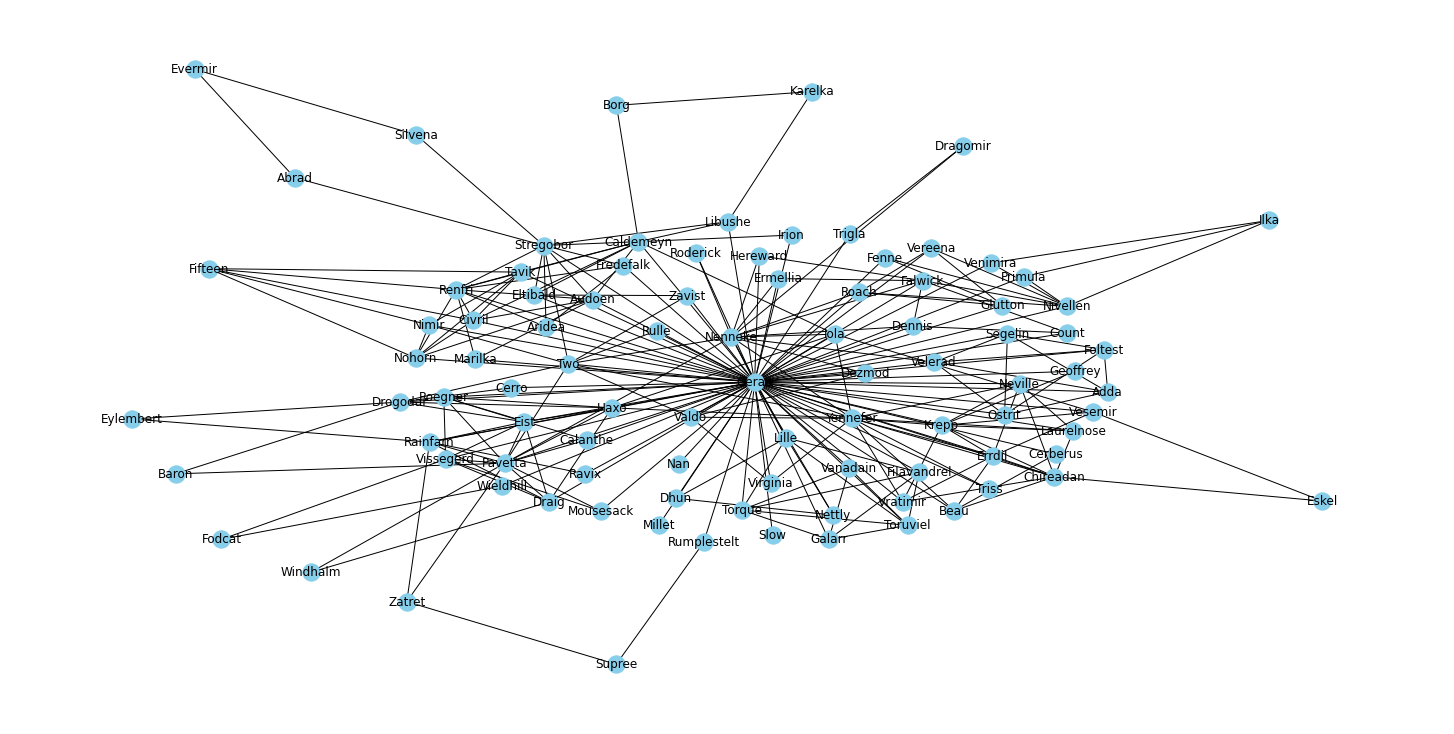

In [83]:
plt.figure(figsize=(20,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color="skyblue", edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

In [94]:
from pyvis.network import Network
net = Network(notebook=True, width="1200px", height="600px", bgcolor="#222222", font_color="white")

node_degree = dict(G.degree)

## setting up node size attribute
nx.set_node_attributes(G, node_degree, "size")

net.from_nx(G)
net.show("witcher.html")

## Most Important characters in The Witcher

In [95]:
## degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict

{'Geralt': 0.8387096774193549,
 'Velerad': 0.06451612903225806,
 'Ostrit': 0.05376344086021506,
 'Adda': 0.05376344086021506,
 'Segelin': 0.05376344086021506,
 'Foltest': 0.05376344086021506,
 'Nenneke': 0.16129032258064518,
 'Iola': 0.06451612903225806,
 'Roach': 0.05376344086021506,
 'Two': 0.10752688172043012,
 'Rulle': 0.021505376344086023,
 'Nivellen': 0.08602150537634409,
 'Glutton': 0.043010752688172046,
 'Fenne': 0.03225806451612903,
 'Primula': 0.03225806451612903,
 'Ilka': 0.03225806451612903,
 'Venimira': 0.03225806451612903,
 'Vereena': 0.043010752688172046,
 'Falwick': 0.07526881720430108,
 'Hereward': 0.03225806451612903,
 'Ermellia': 0.03225806451612903,
 'Dragomir': 0.021505376344086023,
 'Trigla': 0.021505376344086023,
 'Caldemeyn': 0.11827956989247312,
 'Libushe': 0.043010752688172046,
 'Karelka': 0.021505376344086023,
 'Borg': 0.021505376344086023,
 'Irion': 0.021505376344086023,
 'Stregobor': 0.11827956989247312,
 'Zavist': 0.03225806451612903,
 'Eltibald': 0.043010

In [97]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient="index", columns=["centrality"])
degree_df_top_10 = degree_df.sort_values("centrality", ascending=False)[:9]

In [98]:
degree_df_top_10

,centrality
Geralt,0.838710
Nenneke,0.161290
Yennefer,0.161290
Pavetta,0.150538
Caldemeyn,0.118280
Stregobor,0.118280
Renfri,0.118280
Two,0.107527
Haxo,0.096774


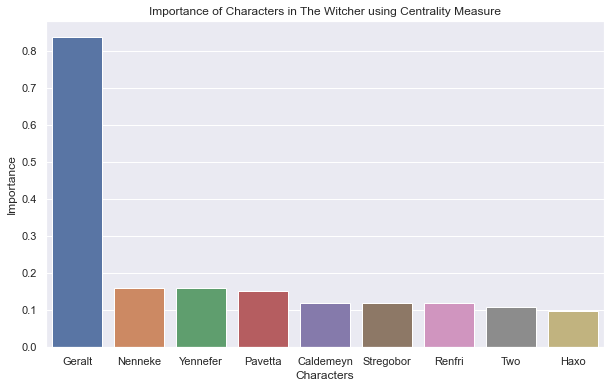

In [102]:
plt.figure(figsize=(10,6))
sns.set_theme(style="darkgrid")
fig = sns.barplot(x=degree_df_top_10.index, y="centrality", data=degree_df_top_10)
plt.title("Importance of Characters in The Witcher using Centrality Measure")
plt.xlabel("Characters")
plt.ylabel("Importance")
plt.show()

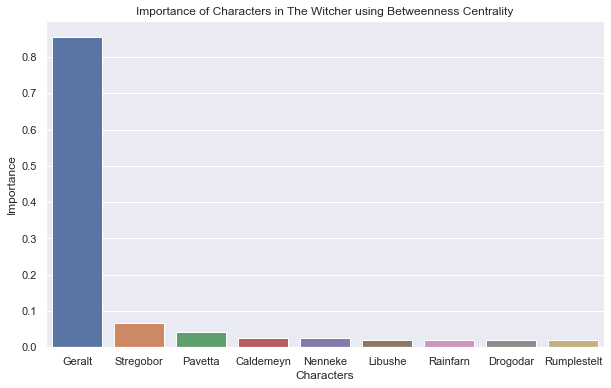

In [104]:
## betweenness centrality
degree_dict_betweenness = nx.betweenness_centrality(G)
degree_df_betweenness = pd.DataFrame.from_dict(degree_dict_betweenness, orient="index", columns=["centrality"])
degree_df_betweenness_top_10 = degree_df_betweenness.sort_values("centrality", ascending=False)[:9]
plt.figure(figsize=(10,6))
sns.set_theme(style="darkgrid")
fig = sns.barplot(x=degree_df_betweenness_top_10.index, y="centrality", data=degree_df_betweenness_top_10)
plt.title("Importance of Characters in The Witcher using Betweenness Centrality")
plt.xlabel("Characters")
plt.ylabel("Importance")
plt.show()

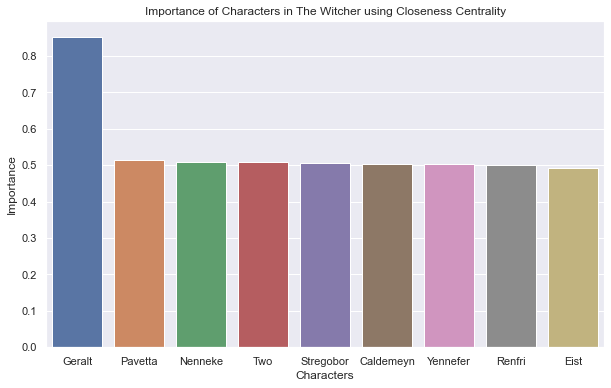

In [106]:
## closeness centrality
degree_dict_closeness = nx.closeness_centrality(G)
degree_df_closeness = pd.DataFrame.from_dict(degree_dict_closeness, orient="index", columns=["centrality"])
degree_df_closeness_top_10 = degree_df_closeness.sort_values("centrality", ascending=False)[:9]
plt.figure(figsize=(10,6))
sns.set_theme(style="darkgrid")
fig = sns.barplot(x=degree_df_closeness_top_10.index, y="centrality", data=degree_df_closeness_top_10)
plt.title("Importance of Characters in The Witcher using Closeness Centrality")
plt.xlabel("Characters")
plt.ylabel("Importance")
plt.show()

In [107]:
## Save centrality measures
nx.set_node_attributes(G, degree_dict, "degree_centrality")
nx.set_node_attributes(G, degree_dict_betweenness, "betweenness_centrality")
nx.set_node_attributes(G, degree_dict_closeness, "closeness_centrality")

## Community Detection

In [109]:
from community import community_louvain
communities = community_louvain.best_partition(G)

In [110]:
communities

{'Geralt': 2,
 'Velerad': 4,
 'Ostrit': 4,
 'Adda': 4,
 'Segelin': 4,
 'Foltest': 4,
 'Nenneke': 2,
 'Iola': 3,
 'Roach': 6,
 'Two': 2,
 'Rulle': 2,
 'Nivellen': 6,
 'Glutton': 6,
 'Fenne': 6,
 'Primula': 6,
 'Ilka': 6,
 'Venimira': 6,
 'Vereena': 6,
 'Falwick': 2,
 'Hereward': 2,
 'Ermellia': 2,
 'Dragomir': 2,
 'Trigla': 2,
 'Caldemeyn': 1,
 'Libushe': 1,
 'Karelka': 1,
 'Borg': 1,
 'Irion': 1,
 'Stregobor': 1,
 'Zavist': 2,
 'Eltibald': 2,
 'Silvena': 1,
 'Evermir': 1,
 'Abrad': 1,
 'Fredefalk': 1,
 'Aridea': 1,
 'Renfri': 1,
 'Nimir': 1,
 'Nohorn': 1,
 'Tavik': 1,
 'Fifteen': 1,
 'Civril': 1,
 'Audoen': 1,
 'Marilka': 1,
 'Vesemir': 3,
 'Yennefer': 3,
 'Haxo': 5,
 'Roegner': 5,
 'Drogodar': 5,
 'Rainfarn': 5,
 'Eylembert': 5,
 'Baron': 5,
 'Pavetta': 5,
 'Eist': 5,
 'Draig': 5,
 'Vissegerd': 5,
 'Fodcat': 5,
 'Wieldhill': 5,
 'Cerro': 5,
 'Mousesack': 5,
 'Calanthe': 5,
 'Windhalm': 5,
 'Zatret': 5,
 'Supree': 5,
 'Rumplestelt': 5,
 'Ravix': 5,
 'Roderick': 2,
 'Millet': 2,
 'Nan':

In [111]:
nx.set_node_attributes(G, communities, "group")

In [114]:
com_net = Network(height="600px", width="1000px", notebook=True, bgcolor="#222222", font_color="white")
com_net.from_nx(G)
com_net.show("witcher_communities.html")